# Multi Agent Demo Recursive and Langraph Combined

See link [LANGGRAPH_COMPARSION](https://github.com/hankbesser/recursive-companion-complete/blob/main/docs/LANGGRAPH_COMPARISON.md) for more.

In [ ]:
#from dotenv import load_dotenv
#load_dotenv()

In [42]:
import os
api_key_status = "Loaded" if os.getenv("OPENAI_API_KEY") else "NOT FOUND - Check your .env file and environment."
print(f"OpenAI API Key status: {api_key_status}")

OpenAI API Key status: Loaded


In [1]:
# imports
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from typing import TypedDict
from recursive_companion.base import MarketingCompanion, BugTriageCompanion, StrategyCompanion

In [2]:
# different models for differents domains
llm_fast  = "gpt-4o-mini"
llm_deep  = "gpt-4.1-mini" 

In [3]:
# create the agents
# tip readthe doctring by hovering over the class
mkt   = MarketingCompanion(llm=llm_fast, temperature=0.8, max_loops=3, similarity_threshold=0.96)
eng   = BugTriageCompanion(llm=llm_deep, temperature=0.3)
plan = StrategyCompanion(llm=llm_fast)

In [4]:
# Each node is now a first-class Runnable; you get built-in tracing, concurrency, retries, etc., without rewriting your engine.
mkt_node  = RunnableLambda(mkt)          # __call__ alias does the trick
eng_node  = RunnableLambda(eng)

In [5]:
# merge-lambda joins text views into one string
# note: LangGraph passes the entire upstream-state dict to a node.
# with out this function, two upstream nodes are piped straight into strategy, 
# so plan_node will receive a Python dict like {"engineering": "...", "marketing": "..."}.
# That's fine if your StrategyCompanion prompt expects that JSON blob, 
# but most of the time you'll want to concatenate the two strings first.

merge_node = RunnableLambda(
    lambda d: f"### Marketing\n{d['marketing']}\n\n### Engineering\n{d['engineering']}"
)
plan_node  = RunnableLambda(plan)

# Define the state schema for LangGraph
class GraphState(TypedDict):
    input: str
    marketing: str
    engineering: str
    merged: str
    final_plan: str

# Inline LangGraph example (fan-in)
# No extra prompts, no schema gymnastics: simply passing text between the callables the classes already expose.
graph = StateGraph(GraphState)
graph.add_node("marketing_agent",    lambda state: {"marketing": mkt_node.invoke(state["input"])})
graph.add_node("engineering_agent",  lambda state: {"engineering": eng_node.invoke(state["input"])})
graph.add_node("merge_agent",        lambda state: {"merged": merge_node.invoke(state)})
graph.add_node("strategy_agent",     lambda state: {"final_plan": plan_node.invoke(state["merged"])})

graph.add_edge("marketing_agent", "merge_agent")
graph.add_edge("engineering_agent", "merge_agent")
graph.add_edge("merge_agent", "strategy_agent")

graph.add_edge("__start__", "marketing_agent")
graph.add_edge("__start__", "engineering_agent")
graph.set_finish_point("strategy_agent")
workflow = graph.compile()

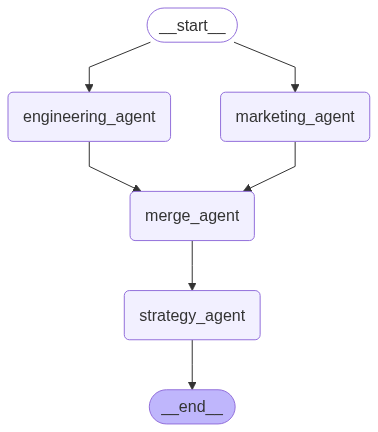

In [6]:
from IPython.display import Image, display
#display the graph
display(Image(workflow.get_graph().draw_mermaid_png()))


In [7]:
result = workflow.invoke(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."}
)

In [8]:
final = result.get("final_plan", "")

In [12]:
print("\n=== FINAL PLAN ===\n")
print(final)


=== FINAL PLAN ===

### Marketing Observations

1. **App Rating Decline:** The app's rating has dropped to 3.2 stars, primarily due to user dissatisfaction related to upload functionality and app stability. Users frequently report losing files during uploads and experiencing crashes on devices running iOS 17.2.

2. **Upload Crashes on iOS 17.2:** Compatibility issues with the latest iOS update are severely affecting user experience. Data loss during uploads is a common complaint in user reviews, indicating an urgent need for resolution.

3. **User Experience vs. App Ratings:** A clear link exists between upload issues and declining app ratings. Addressing these upload problems is critical for improving user satisfaction and reversing the decline in ratings.

4. **Impact of iOS Updates:** The release of iOS 17.2 coincides with the onset of upload crashes, suggesting a direct relationship between the update and app performance that requires immediate attention.

### Engineering Observat

In [13]:
# === After LangGraph workflow completes ===
print("\n🔍 DEEP INTROSPECTION - What LangGraph CAN'T normally show you:\n")
# Show iteration counts
print(f"Marketing iterations: {len(mkt.run_log)}")
print(f"Engineering iterations: {len(eng.run_log)}")
print(f"Strategy iterations: {len(plan.run_log)}")
# Show why each converged
print("\n📊 CONVERGENCE ANALYSIS:")
for name, agent in [("Marketing", mkt), ("Engineering", eng), ("Strategy", plan)]:
    if len(agent.run_log) < agent.max_loops:
        print(f"{name}: Converged early (quality threshold reached)")
    else:
        print(f"{name}: Used all {agent.max_loops} iterations")



🔍 DEEP INTROSPECTION - What LangGraph CAN'T normally show you:

Marketing iterations: 2
Engineering iterations: 3
Strategy iterations: 2

📊 CONVERGENCE ANALYSIS:
Marketing: Converged early (quality threshold reached)
Engineering: Used all 3 iterations
Strategy: Converged early (quality threshold reached)


In [14]:
# Show full thinking process for marketing agent
print("\n🧠 MARKETING THINKING PROCESS:")
print(mkt.transcript_as_markdown())



🧠 MARKETING THINKING PROCESS:
--------------------------------------------------------------------------------
## Initial Draft
--------------------------------------------------------------------------------
The current marketing challenge presents several key market signals that require thorough examination:

### Key Market Signals and Issues

1. **App Rating Decline:**
   - The app's rating has fallen to 3.2 stars, indicating a significant drop in user satisfaction. This decline suggests that users may be experiencing issues that impact their overall perception of the app.

2. **Upload Crashes on iOS 17.2:**
   - A specific technical issue has emerged where uploads are crashing on devices running iOS 17.2. This suggests compatibility problems with the latest operating system update, which could drastically affect user experience and engagement.

### Apparent Relationships

- **User Experience vs. App Ratings:**
  - There appears to be a direct correlation between the upload crash i

In [15]:
# Show full thinking process for engineering agent
print("\n🔧 ENGINEERING THINKING PROCESS:")
print(eng.transcript_as_markdown())



🔧 ENGINEERING THINKING PROCESS:
--------------------------------------------------------------------------------
## Initial Draft
--------------------------------------------------------------------------------
1. Reported Symptoms:
   - App ratings have dropped to an average of 3.2 stars, indicating user dissatisfaction.
   - Upload functionality crashes consistently on devices running iOS 17.2.
   - Crash logs (if available) were not provided.
   - No specific device models or iOS 17.2 subversions mentioned.
   - No details on whether the crash occurs during specific upload types or file sizes.

2. Apparent Correlations:
   - Crashes are reported specifically on iOS 17.2, suggesting a possible compatibility or regression issue with this OS version.
   - The drop in app ratings may be correlated with the upload crash issue, but the extent of other user complaints is unclear.

3. Information Gaps:
   - Detailed crash logs or stack traces related to the upload crash are missing.
   - R

In [16]:
# Show full thinking process for strategy agent after merged view
print("\n🎯 STRATEGY SYNTHESIS PROCESS:")
print(plan.transcript_as_markdown())


🎯 STRATEGY SYNTHESIS PROCESS:
--------------------------------------------------------------------------------
## Initial Draft
--------------------------------------------------------------------------------
### Integrated Overview

#### Marketing Observations
1. **App Rating Decline:** The app's rating has dropped to 3.2 stars, primarily attributed to user dissatisfaction stemming from issues with upload functionality and app stability. Many users report losing files during uploads and experiencing crashes, particularly on iOS 17.2.
2. **Upload Crashes on iOS 17.2:** There are significant compatibility issues with the latest iOS update that are drastically affecting user experience, as users frequently mention data loss during uploads.
3. **User Experience vs. App Ratings:** A direct correlation exists between the upload issues and the declining ratings, indicating that resolving these problems could enhance user satisfaction.
4. **Impact of iOS Updates:** The timing of the crashes 